In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from cleverhans.attacks import FastGradientMethod, LBFGS
from cleverhans.utils_keras import KerasModelWrapper

from keras.datasets import cifar10
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
kmodel = load_model('../Saved_models/vgg16_cifar.h5')
K.set_learning_phase(0)
model = KerasModelWrapper(kmodel)
sess = K.get_session()

/home/calvin/python3/lib/python3.5/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
kmodel.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 375us/step


[0.1841043361902237, 0.9274299864768982]

In [5]:
fgsm = FastGradientMethod(model, sess=sess)
# adv_target[0, 340] = 1
fgsm_params = {'eps': 0.025,
               'clip_min': 0,
               'clip_max': 1}

In [ ]:
adv = fgsm.generate_np(x_test, **fgsm_params)

In [6]:
def batches(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
# Batch to avoid ResourceExhaustedError
adv = np.ndarray(shape=(0, 32, 32, 3))
for batch in tqdm_notebook(batches(x_test, 100)):
    adv = np.append(adv, fgsm.generate_np(batch, **fgsm_params), axis=0)

In [16]:
kmodel.evaluate(adv, y_test)

10000/10000 [==============================] - 1s 64us/step


[3.1900811573028562, 0.167]

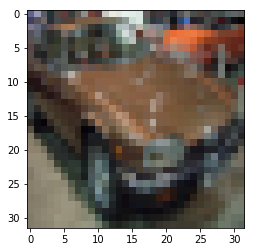

In [17]:
plt.imshow(x_test[2000])

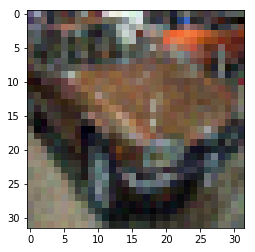

In [18]:
plt.imshow(adv[2000])

**Only attack the test cases that were correct**

In [64]:
pred = kmodel.predict(x_test)
pred = pred.argmax(axis=1).reshape(-1, 1)

In [65]:
pred = to_categorical(pred)

In [70]:
x_test_correct = x_test[(pred == y_test).all(axis=1)].copy()
y_test_correct = y_test[(pred == y_test).all(axis=1)].copy()

In [ ]:
# Batch to avoid ResourceExhaustedError
adv1 = np.ndarray(shape=(0, 32, 32, 3))
for batch in tqdm_notebook(batches(x_test_correct, 100)):
    adv1 = np.append(adv1, fgsm.generate_np(batch, **fgsm_params), axis=0)

In [82]:
kmodel.evaluate(adv1, y_test_correct)

7874/7874 [==============================] - 1s 65us/step


[3.492510889458844, 0.10223520447040894]

In [92]:
pred2 = kmodel.predict(adv1)
pred2 = pred2.argmax(axis=1).reshape(-1, 1)

In [93]:
pred2 = to_categorical(pred2)
pred2[(pred2 == y_test_correct).all(axis=1)].sum()

805.0

In [94]:
805 / 10000

0.0805